In [2]:
# if (!requireNamespace('BiocManager', quietly = TRUE))
# install.packages('BiocManager') BiocManager::install('ComplexHeatmap')
# install.packages(c('ClusterR','tidyverse'))
# suppressMessages(require(pheatmap))
require(ComplexHeatmap)
suppressMessages(require(tidyverse))
suppressMessages(require(data.table))
require(RColorBrewer)
# require(ClusterR) require(pracma)

In [3]:
(meta.dat <- fread("../data_processed/meta_data.csv") %>% mutate(dpi = as.factor(`Day Post-Infection`), 
    Age = factor(`Host Age Category`, levels = c("young", "adult", "aged")), Strain = as.factor(`Viral Strain`)) %>% 
    select("Time_BiosetID", Age, Strain, dpi) ) %>% 
    summary

 Time_BiosetID         Age                Strain    dpi    
 Length:74          young:28   SARS-CoV-ic   : 4   0.5: 6  
 Class :character   adult:37   SARS-CoV-MA15 :54   1  :15  
 Mode  :character   aged : 9   SARS-CoV-MA15e: 7   2  :19  
                               SARS-CoV-MA15g: 7   4  :19  
                               SARS-CoV-TOR-2: 2   7  :15  

In [4]:
(dat <- fread("../data_processed/plot_dat.csv") %>%
    column_to_rownames("V1")) %>%
    head(1)
dat %>%
    dim

(glist <- fread("../data_processed/bootstrap/bootstrap_features_selected.csv", header = T) %>%
    column_to_rownames("gene")) %>%
    head(1)

,0.5_867451,0.5_867454,0.5_867457,0.5_867478,0.5_867481,0.5_867484,1_926614,1_494014,1_494017,1_494020,⋯,7_685178,7_685217,7_821662,7_823408,7_839434,7_839446,7_833455,7_840319,7_834112,7_995287
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
March1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


[1] 10564    74

,counts,avg_weight,std_weight
,<int>,<dbl>,<dbl>
Adm,100,-0.1208498,0.08808907


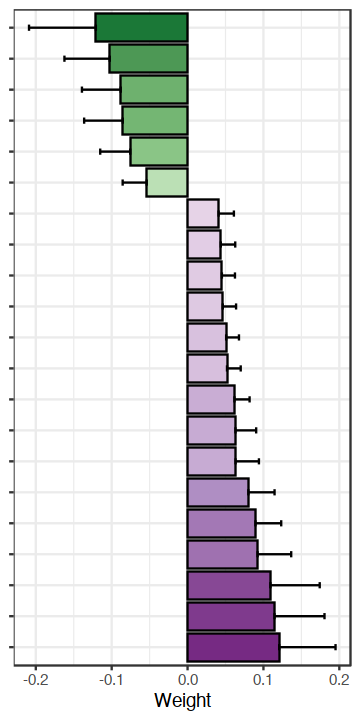

In [5]:
options(repr.plot.width = 3, repr.plot.height = 6)

p.weight_bar = ggplot(glist %>%
    rownames_to_column("gene") %>%
    mutate(gene = factor(gene, levels = glist %>%
        rownames %>%
        rev)), aes(gene, avg_weight, fill = avg_weight)) + geom_bar(stat = "identity",
    color = "black") + scale_fill_distiller(palette = "PRGn") + geom_errorbar(aes(ymin = avg_weight,
    ymax = ifelse(avg_weight > 0, avg_weight + std_weight, avg_weight - std_weight)),
    width = 0.2, position = position_dodge(0.9)) + coord_flip() + theme_bw() + theme(legend.position = "none",
    axis.text.y = element_blank(), axis.title.y = element_blank()) + ylab(label = "Weight")
p.weight_bar

In [11]:
require(svglite)
ggsave("fig7a.svg",width = 3,height = 6)

In [12]:
options(repr.plot.width = 10, repr.plot.height = 5)
n = 0
anno_colors <- list(stage = c(early = brewer.pal(n = 11, "PRGn")[11 - n], late = brewer.pal(n = 11,
    "PRGn")[1 + n]), dpi = c(`0.5` = brewer.pal(n = 9, "Set1")[1], `1` = brewer.pal(n = 9,
    "Set1")[2], `2` = brewer.pal(n = 9, "Set1")[3], `4` = brewer.pal(n = 9, "Set1")[4],
    `7` = brewer.pal(n = 9, "Set1")[5]), variant = c(`SARS-CoV-ic` = brewer.pal(n = 8,
    "Set2")[5], `SARS-CoV-MA15` = brewer.pal(n = 8, "Set2")[1], `SARS-CoV-MA15g` = brewer.pal(n = 8,
    "Set2")[2], `SARS-CoV-MA15e` = brewer.pal(n = 8, "Set2")[3], `SARS-CoV-TOR-2` = brewer.pal(n = 8,
    "Set2")[4]), age = c(young = brewer.pal(n = 12, "Set3")[3], adult = brewer.pal(n = 12,
    "Set3")[2], aged = brewer.pal(n = 12, "Set3")[1]))

pal_atac <- colorRampPalette(c("#3361A5", "#248AF3", "#14B3FF", "#88CEEF", "#C1D5DC",
    "#EAD397", "#FDB31A", "#E42A2A", "#A31D1D"))(100)
pal_atac <- colorRampPalette(c("blue", "black", "yellow"))(100)

col.gap = dat %>%
    colnames %>%
    sapply(., function(x) (strsplit(x, split = "_") %>%
        unlist)[1]) %>%
    table %>%
    cumsum

df_col_anno = data.frame(col_name = dat %>%
    colnames) %>%
    separate(col_name, c("time", "s"), remove = F, sep = "_") %>%
    mutate(stage = ifelse(time %in% c("0.5", "1", "2"), "early", "late")) %>%
    select(-s) %>%
    column_to_rownames("col_name")

df_col_anno <- df_col_anno %>%
    rownames_to_column("Time_BiosetID") %>%
    left_join(meta.dat) %>%
    column_to_rownames("Time_BiosetID") %>%
    select(-time) %>%
    select(stage, dpi, Strain, Age) %>%
    rename(variant = "Strain", age = "Age")


p <- pheatmap(dat[glist %>%
    rownames, ], annotation_col = df_col_anno, name = "CE score", annotation_colors = anno_colors,
    show_colnames = F, border_color = NA, gaps_col = col.gap, scale = "none", color = pal_atac,
    cluster_rows = F, cluster_cols = F, show_rownames = T, gaps_row = sum(glist$avg_weight <
        0))

Joining, by = "Time_BiosetID"

Warning message:
“The input is a data frame, convert it to the matrix.”


In [15]:
svglite('fig7b.svg',width = 10,height = 5)
print(p)
dev.off()

pdf 
  2

In [12]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Catalina 10.15.7

Matrix products: default
BLAS/LAPACK: /Users/fcheng/opt/miniconda3/envs/r4-base/lib/libopenblasp-r0.3.12.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ComplexHeatmap_2.6.2 RColorBrewer_1.1-2   data.table_1.14.0   
 [4] forcats_0.5.1        stringr_1.4.0        dplyr_1.0.7         
 [7] purrr_0.3.4          readr_1.4.0          tidyr_1.1.3         
[10] tibble_3.1.0         ggplot2_3.3.3        tidyverse_1.3.1     
[13] pheatmap_1.0.12      jsonlite_1.7.2       formatR_1.7         

loaded via a namespace (and not attached):
 [1] httr_1.4.2          modelr_0.1.8        assertthat_0.2.1   
 [4] stats4_4.0.3        cellranger_1.1.0    pillar_1.6.1       
 [7] backports_1.2.1     glue_1.4.2          uui